This notebook aims to produce transport layers that are fit for the model.

Transport modes are among: roads, railways, waterways, maritime, and multimodal. Roads are required. Note that the multimodal is required if there are more than 2 transport modes.

### Input
- For each mode, a `raw_<mode>_edges.geojson` and and a `raw_<mode>_nodes.geoson`, except for multimodal for which there is only a edge layer
- Required attributes :
    - `raw_roads_edges.geojson`: "class" ("primary", "seconday", etc.), "surface" ("paved, "unpaved")
    - `raw_multimodal_edges.geojson`: "multimodes" ("roads-railways", "roads-maritime", etc.)
    - For the countri
- Optional attributes :
    - `raw_<mode>_edges.geojson`: "capacity" (float, max daily tonnage on the edge)
- Other requirements :
    - the location of countries should be placed in the nodes layers
    - concretely, there should be a "name" attribute in `raw_<mode>_nodes.geoson`, with the trigram of the country in the selected node
       
### Output
- For each mode, a `<mode>_edges.geojson` and a `<mode>_nodes.geoson`
- New attributes :
    - `<mode>_edges.geojson` and `<mode>_nodes.geoson`: 'id' (integer)
    - `<mode>_edges.geojson`: 'end1' and 'end2' (integer, id of nodes located at the end of the edges), 'km' (float, length of edge)
    - Note that the end1 and end2 of edges are found with looking at the node of `<mode>_nodes.geoson` which is the closed to the ends of the dege
- Modification on the geometry
    - (optional) `<mode>_nodes.geoson`: if the end1 or end2 nodes are not located at the ends of the edges, they are moved to the ends of the edges
    - (optional) `<mode>_nodes.geoson`: if there are several points very close to each others (distance epsilon), merge them

### Folder path
- input files : in the input_folder, there should be one subfolder per mode, named `<Mode>` with the files
- output : defined by output_folder

### Points to improve
- we could think of not using a `raw_<mode>_nodes.geoson` and generate the nodes directly from the ends of edges
- but we need to say where the countries are

In [1]:
region = "ECA"

In [2]:
import os
import time
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import shapely.wkt
from tqdm import tqdm

if region == "Italia":
    input_folder = os.path.join('..', '..', '..', '..', 'Research', 'Elisa', "disruptsc-ita", "input", "Italy", "Transport")
else:
    input_folder = os.path.join('..', '..', '..', region, 'Data', 'Structured', "Transport")

output_folder = os.path.join('..', 'input', region, 'Transport')

In [3]:
projected_crs = {
    'Cambodia': 3857,
    'Ecuador': 31986,
    'ECA': 3857,
    'Italia': 32633
}
projected_crs = projected_crs[region]

In [4]:
def loadShp(filename):
    gpdf = gpd.read_file(filename)
    gpdf = gpdf[~gpdf['geometry'].isnull()]
    gpdf = gpdf.to_crs(epsg=4326)
    return gpdf

In [18]:
def createNodes(df_links):
    all_coords = df_links['geometry'].apply(getEndCoordsFromLine).to_list()
    all_coords = list(set([item for sublist in all_coords for item in sublist]))
    return gpd.GeoDataFrame({"geometry": [Point(coords) for coords in all_coords], "id": range(len(all_coords))}, crs=4326)

def getEndCoordsFromLine(linestring_obj):
    end1Coord = linestring_obj.coords[0]
    end2Coord = linestring_obj.coords[-1]
    return [end1Coord, end2Coord]

def getEndPointsFromLine(linestring_obj):
    end1Coord = linestring_obj.coords[0]
    end2Coord = linestring_obj.coords[-1]
    return Point(*end1Coord), Point(*end2Coord)

def getIndexClosestPoint(point, df_with_points):
    distList = [point.distance(item) for item in df_with_points['geometry'].tolist()]
    return int(df_with_points.index[distList.index(min(distList))])

def updateLineString(linestring_obj, newEnd1, newEnd2):
    return LineString([newEnd1.coords[0]] + linestring_obj.coords[1:-1]+[newEnd2.coords[0]])

def assignEndpointsAndUpdate(df_links, id_link, df_nodes, update=False):
    p1, p2 = getEndPointsFromLine(df_links.loc[id_link, 'geometry'])
    id_closest_point1 = getIndexClosestPoint(p1, df_nodes)
    id_closest_point2 = getIndexClosestPoint(p2, df_nodes)
    df_links.loc[id_link, 'end1'] = id_closest_point1
    df_links.loc[id_link, 'end2'] = id_closest_point2
    if update:
        df_links.loc[id_link, 'geometry'] = updateLineString(df_links.loc[id_link, 'geometry'], df_nodes.loc[id_closest_point1, 'geometry'], df_nodes.loc[id_closest_point2, 'geometry'])
    return df_links

def assignEndpointsAndUpdateFullDf(df_links, df_nodes, update=False):
    print('Assigning end nodes to linestring')
    if update:
        print('Stag liens to endnodes')
    res = df_links.copy()
    for i in tqdm(res.index):
        res = assignEndpointsAndUpdate(res, i, df_nodes, update=update)
    res['end1'] = res['end1'].astype(int)
    res['end2'] = res['end2'].astype(int)
    return res

def getAllEndpoints(df_links):
    all_endpoints = [getEndPointsFromLine(item) for item in df_links['geometry']]
    return [item for sublist in all_endpoints for item in sublist]

def mergePoints(df_nodes, df_links, epsilon):
    print("Nb of original nodes:", df_nodes.shape[0])
    
    all_endpoints = getAllEndpoints(df_links)
    print("Nb of endpoints:", len(all_endpoints))
    
    all_points_gpd = gpd.GeoDataFrame({"geometry": df_nodes['geometry'].tolist()+getAllEndpoints(df_links)}, crs={'epsg':'4326'})
    buffered_polygons = gpd.GeoDataFrame({"geometry": all_points_gpd.buffer(distance=epsilon)}, crs={'epsg':'4326'})
    multipolygon = buffered_polygons.unary_union
    centroids_each_polygon = [polygon.centroid for polygon in multipolygon]
    print("Nb of grouped points:", len(centroids_each_polygon))
    
    return gpd.GeoDataFrame({"id":range(len(multipolygon)), "geometry":centroids_each_polygon}, crs={'epsg':'4326'})

def assignEndpointsOneEdge(row, df_nodes):
    p1, p2 = getEndPointsFromLine(row['geometry'])
    id_closest_point1 = getIndexClosestPoint(p1, df_nodes)
    id_closest_point2 = getIndexClosestPoint(p2, df_nodes)
    row['end1'] = id_closest_point1
    row['end2'] = id_closest_point2
    return row

def assignEndpoints(df_links, df_nodes):
    return df_links.apply(lambda row: assignEndpointsOneEdge(row, df_nodes), axis=1)

In [19]:
def loadAndFormatGeojson(transport_mode, nodeedge, subfolder, suffix=""):
    if nodeedge == "nodes":
        nodes = gpd.read_file(os.path.join(subfolder, "raw_"+transport_mode+"_nodes"+suffix+".geojson"))
        if 'index' in nodes.columns:
            nodes = nodes.drop('index', axis=1)
        nodes['id']=range(nodes.shape[0])
        nodes.index = nodes['id']
        nodes.index.name = "index"
        print("There are", nodes.shape[0], "nodes")
        print(nodes.crs)
        return nodes
    
    if nodeedge == "edges":
        edges = gpd.read_file(os.path.join(subfolder, "raw_"+transport_mode+"_edges"+suffix+".geojson"))
        edges = edges[~edges['geometry'].isnull()]
        if 'index' in edges.columns:
            edges = edges.drop('index', axis=1)
        edges['id']=range(edges.shape[0])
        edges['end1'] = None
        edges['end2'] = None
        if "capacity" not in edges.columns:
            edges['capacity'] = None
        edges.index = edges['id']
        edges.index.name = "index"
        print("There are", edges.shape[0], "edges")
        print(edges.crs)
        return edges
    
    
def addKm(edges, crs):
    # Project the layer. Watch out, the CRS should be adapted to the country
    edges['km'] = edges.to_crs({'init': 'epsg:'+str(crs)}).length/1000
    return edges


def create_nodes_from_edges(gpd_edges):
    endpoints = gpd.GeoDataFrame(
        {"geometry": gpd_edges.geometry.apply(lambda line: [Point(line.coords[0]), Point(line.coords[-1])]).explode()}
    ).reset_index(drop=True)
    tolerance = 6

    # Round the x and y coordinates and create a new column for duplicate detection
    endpoints['rounded_geometry'] = endpoints.geometry.apply(lambda geom: (round(geom.x, tolerance), round(geom.y, tolerance)))
    
    # Drop duplicates based on the rounded coordinates
    unique_endpoints = endpoints.drop_duplicates(subset='rounded_geometry')['geometry']

    nodes = gpd.GeoDataFrame(geometry=unique_endpoints.values, crs=gpd_edges.crs)
    nodes['id'] = range(nodes.shape[0])
    return nodes

In [20]:
from shapely.ops import linemerge, unary_union


def export(nodes, edges, input_folder, output_folder, transport_mode, special_suffix):
    subfolder = os.path.join(input_folder, transport_mode.capitalize())
    
    filename = os.path.join(output_folder, transport_mode+"_edges"+special_suffix+".geojson")
    edges.to_file(filename, driver="GeoJSON", index=False)
    print(filename + ' exported')
    
    filename = os.path.join(subfolder, "treated_"+transport_mode+"_edges"+special_suffix+".geojson")
    edges.to_file(filename, driver="GeoJSON", index=False)
    print(filename + ' exported')
    
    filename = os.path.join(subfolder, "treated_"+transport_mode+"_nodes"+special_suffix+".geojson")
    nodes.to_file(filename, driver="GeoJSON", index=False)
    print(filename + ' exported')


def create_nodes_and_update_edges(edges):
    # create nodes from endpoints
    endpoints = gpd.GeoDataFrame({"end1": edges.geometry.apply(lambda line: Point(line.coords[0])), "end2": edges.geometry.apply(lambda line: Point(line.coords[-1]))})
    all_endpoints = gpd.GeoDataFrame(pd.concat([endpoints['end1'], endpoints['end2']]), columns=["geometry"], crs=edges.crs)
    all_endpoints['geometry_wkt'] = all_endpoints['geometry'].to_wkt()
    nodes = all_endpoints.drop_duplicates('geometry_wkt').copy()
    nodes['id'] = range(nodes.shape[0])
    nodes.index = nodes['id']
    
    # add nodes_id into end1 and end2 columns of edges
    edges['end1'] = endpoints['end1'].to_wkt().map(nodes.set_index('geometry_wkt')['id'])
    edges['end2'] = endpoints['end2'].to_wkt().map(nodes.set_index('geometry_wkt')['id'])

    return nodes, edges

# Roads

In [201]:
import re
from tqdm import tqdm


def get_merge_nodes(edges):
    end_points_connectivity = pd.concat([edges['end1'], edges['end2']]).value_counts()
    merge_points = end_points_connectivity[end_points_connectivity == 2].index.sort_values().to_list()
    return merge_points


def get_edges_from_endpoints(edges, endpoints: list):
    merged_df_end1 = pd.merge(pd.DataFrame({'endpoint': endpoints}), edges[['id', 'end1']].rename(columns={'id': 'edge_id', 'end1': 'endpoint'}), on='endpoint', how='left').dropna().astype(int)
    merged_df_end2 = pd.merge(pd.DataFrame({'endpoint': endpoints}), edges[['id', 'end2']].rename(columns={'id': 'edge_id', 'end2': 'endpoint'}), on='endpoint', how='left').dropna().astype(int)
    merged_df = pd.concat([merged_df_end1, merged_df_end2])
    return merged_df.groupby("endpoint")['edge_id'].apply(list).to_dict()


def check_degree2(node_id_to_edges_ids: dict):
    return (pd.Series(node_id_to_edges_ids).apply(len) == 2).all()
    

def merge_edges_attributes(gdf):
    new_data = {}
    new_data['geometry'] = linemerge(unary_union(gdf.geometry))
    if new_data['geometry'].geom_type != "LineString":
        print(gdf.geometry)
        print(new_data['geometry'])
        raise ValueError(f"Merged geometry is: {new_data['geometry'].geom_type}")

    def string_to_list(s):
        return list(map(int, re.findall(r'\d+', s)))
    def merge_or_unique(column):
        unique_vals = gdf[column].dropna().unique()
        return unique_vals[0] if len(unique_vals) == 1 else ', '.join(unique_vals)
        
    # Aggregate columns based on given rules
    if 'km' in gdf.columns:
        new_data['km'] = gdf['km'].sum()
    if 'osmids' in gdf.columns:
        new_data['osmids'] = str(string_to_list(', '.join(map(str, gdf['osmids'].fillna('')))))
    if 'name' in gdf.columns:
        new_data['name'] = ', '.join(filter(None, gdf['name'].astype(str)))  # Ignore None values
    if 'capacity' in gdf.columns:
        new_data['capacity'] = gdf['capacity'].min()
    for col in ['end1', 'end2']:
        if col in gdf.columns:
            new_data[col] = None
    for col in ['special', 'class', 'surface', 'disruption']:
        if col in gdf.columns:
            new_data[col] = merge_or_unique(col)

    # Create a new row with the merged data
    return new_data

def update_gdf(gdf, new_data, old_ids, new_id):
    for col, value in new_data.items():
        gdf.at[new_id, col] = value
    gdf.loc[list(set(old_ids) - {new_id}), 'to_keep'] = False


def update_dict(my_dict, old_value, new_value):
    for key, value_list in my_dict.items():
        if old_value in value_list:
            my_dict[key] = [new_value if v == old_value else v for v in value_list]
    return my_dict


def remove_degree_2_nodes(edges):
    merge_nodes = get_merge_nodes(edges)
    print(f"Nb degree 2 nodes: {len(merge_nodes)}")
    merge_nodes_with_edges_ids = get_edges_from_endpoints(edges, merge_nodes)
    print(f"Check that they are actually 2 edges associated: {check_degree2(merge_nodes_with_edges_ids)}")
    
    edges['to_keep'] = True
    edges = edges.set_index('id')
    for merged_node in tqdm(list(merge_nodes_with_edges_ids.keys())):
        edge_ids = merge_nodes_with_edges_ids.pop(merged_node)
        print(edge_ids)
        merged_attributes = merge_edges_attributes(edges.loc[edge_ids])
        old_id = max(edge_ids)
        new_id = min(edge_ids)
        update_gdf(edges, merged_attributes, edge_ids, new_id)
        merge_nodes_with_edges_ids = update_dict(merge_nodes_with_edges_ids, old_id, new_id)
    
    print(f"Check that all resulting geometries are LineString: {edges['geometry'].apply(lambda geom: geom.geom_type == 'LineString').all()}")
    
    edges = edges[edges['to_keep']]
    edges = edges.drop(columns=['to_keep'])
    edges = edges.reset_index()
    return edges

s = remove_degree_2_nodes(edges)

Nb degree 2 nodes: 3013
Check that they are actually 2 edges associated: True


  0%|▏                                                                               | 8/3013 [00:00<00:19, 157.81it/s]

[18, 876]
[73, 78]
[108, 858]
[110, 423]
[125, 241]
[142, 324]
[146, 530]
[152, 153]
[157, 1422]
id
157     LINESTRING (46.53166 38.89632, 46.53053 38.898...
1422    LINESTRING (46.53166 38.89632, 46.53053 38.898...
Name: geometry, dtype: geometry
MULTILINESTRING ((46.49164150349149 38.890866281292595, 46.4911860911759 38.89070078615641, 46.48898660011175 38.89108300012184, 46.487667599999895 38.891661, 46.4836334999999 38.8944834, 46.482557905059835 38.89494783931255, 46.48116409999998 38.89532079999997, 46.479830538890134 38.89564102057518, 46.47800719999994 38.89597559999995, 46.47472000113206 38.89531860609513, 46.47416829999995 38.89309849999997, 46.47251410620896 38.89180122811302, 46.4700658999999 38.891044, 46.46902 38.8909813, 46.465695 38.8915274, 46.46432169999991 38.8923958, 46.46320589999991 38.8935315, 46.460341299999904 38.8978151, 46.458378499999924 38.898795200000116, 46.45617966764101 38.89951347450105, 46.45372375000035 38.89973790022023, 46.45013175038911 38.8997280

ValueError: Merged geometry is: MultiLineString

In [ ]:
import geopandas as gpd
from shapely.ops import split
from shapely.geometry import LineString, MultiPoint

def split_lines_at_intersections(gdf):
    intersection_points = []

    # Step 1: Find all intersection points
    for i, line1 in gdf.geometry.items():
        for j, line2 in gdf.geometry.items():
            if i < j:  # Avoid duplicate checks
                intersection = line1.intersection(line2)
                if intersection.is_empty:
                    continue
                if "Point" in intersection.geom_type:  # Single intersection point
                    intersection_points.append(intersection)
                elif "MultiPoint" in intersection.geom_type:  # Multiple intersection points
                    intersection_points.extend(list(intersection.geoms))
                elif "LineString" in intersection.geom_type:  # Multiple intersection points
                    intersection_points.extend(list(intersection.geoms))

    intersection_points = MultiPoint(intersection_points)  # Convert list to MultiPoint

    # Step 2: Split each LineString at the intersection points
    new_geometries = []
    for line in gdf.geometry:
        split_result = split(line, intersection_points)
        new_geometries.extend(split_result.geoms)  # Store split segments

    # Step 3: Create a new GeoDataFrame with split lines
    new_gdf = gpd.GeoDataFrame(geometry=new_geometries, crs=gdf.crs)
    
    return new_gdf

# Example usage
gdf = gpd.read_file("your_lines.geojson")  # Load your line data
split_gdf = split_lines_at_intersections(gdf)

# Save or visualize the result
split_gdf.to_file("split_lines.geojson", driver="GeoJSON")
print(split_gdf)


In [276]:
line1 = LineString([(0, 0), (2, 2), (3, 3), (4, 4), (5, 6), (6, 6), (7, 7)])  # Diagonal line
line2 = LineString([(0, 1), (2, 0), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)])  # Another diagonal line crossing the first

# Check intersection
print(line1.overlaps(line2))
intersection = line1.intersection(line2)
intersection.wkt

True


'GEOMETRYCOLLECTION (LINESTRING (3 3, 4 4), LINESTRING (6 6, 7 7), POINT (0.6666666666666666 0.6666666666666666))'

In [267]:
line1 = LineString([(5, 6), (6, 6), (7, 7)])  # Diagonal line
line2 = LineString([(5, 5), (6, 6), (7, 7)])  # Another diagonal line crossing the first

# Check intersection
print(line1.overlaps(line2))
intersection = line1.intersection(line2)
intersection.wkt

True


'LINESTRING (6 6, 7 7)'

In [251]:
new_geom = line1.difference(intersection)
print(new_geom.wkt)
linestring_list = [geom for geom in new_geom.geoms]
print(linestring_list)
print(line2.wkt)

MULTILINESTRING ((0 0, 2 2, 3 3), (4 4, 5 6, 6 7, 7 7))
[<LINESTRING (0 0, 2 2, 3 3)>, <LINESTRING (4 4, 5 6, 6 7, 7 7)>]
LINESTRING (0 2, 2 0, 3 3, 4 4, 5 5, 6 6, 7 7)


In [263]:
split(line1, LineString([(3, 3), (4, 4)]))

ValueError: Input geometry segment overlaps with the splitter.

In [272]:
t = gpd.GeoDataFrame({"geometry":[line1, line2]})
t.loc[1, "geometry"] = None
t

,geometry
0,"LINESTRING (5 6, 6 6, 7 7)"
1,None


In [300]:
treat_overlapping_linestrings(line1, line2)

MULTILINESTRING ((0 0, 0.6666666666666666 0.6666666666666666), (0.6666666666666666 0.6666666666666666, 2 2, 3 3), (4 4, 5 6, 6 6))


([<LINESTRING (3 3, 4 4)>, <LINESTRING (6 6, 7 7)>],
 [<LINESTRING (0 0, 0.7 0.7)>,
  <LINESTRING (0.7 0.7, 2 2, 3 3)>,
  <LINESTRING (4 4, 5 6, 6 6)>])

In [298]:
print(line1.wkt, line2.wkt)

LINESTRING (0 0, 2 2, 3 3, 4 4, 5 6, 6 6, 7 7) LINESTRING (0 1, 2 0, 3 3, 4 4, 5 5, 6 6, 7 7)


In [297]:
line1.difference(line2).wkt

'MULTILINESTRING ((0 0, 0.6666666666666666 0.6666666666666666), (0.6666666666666666 0.6666666666666666, 2 2, 3 3), (4 4, 5 6, 6 6))'

In [291]:
overlapping_parts = geometry_to_list_of_single_geom(line1.intersection(line2), "LineString")
line1.difference(overlapping_parts)

array([<MULTILINESTRING ((0 0, 2 2, 3 3), (4 4, 5 6, 6 6, 7 7))>,
       <LINESTRING (0 0, 2 2, 3 3, 4 4, 5 6, 6 6)>], dtype=object)

In [284]:
def geometry_to_list_of_single_geom(geom, target_type: str):
    if (geom.geom_type == "Linestring") and (target_type== "LineString"):
        return [geom]
    if (geom.geom_type == "Point") and (target_type == "Point"):
        return [geom]
    if (geom.geom_type == "MultiLineString") and (target_type == "LineString"):
        return [single_geom for single_geom in geom.geoms]
    if (geom.geom_type == "MultiPoint") and (target_type == "Point"):
        return [single_geom for single_geom in geom.geoms]
    if geom.geom_type == "GeometryCollection":
        single_geoms = [single_geom for single_geom in geom.geoms]
        return [single_geom for single_geom in geom.geoms if single_geom.geom_type == target_type]

In [310]:
def treat_overlapping_linestrings(line0, line1):
    if line0.within(line1):
        return None, line1
    elif line1.within(line0):
        return line0, None
    elif line0.overlaps(line1):
        overlapping_parts = geometry_to_list_of_single_geom(line0.intersection(line1), "LineString")
        new_line0 = overlapping_parts
        remaining_geom = line0.difference(line1)
        if remaining_geom.geom_type == "LineString":
            new_line1 = [remaining_geom]
        elif remaining_geom.geom_type == "MultiLineString":
            new_line1 = [geom for geom in remaining_geom.geoms]
        return new_line0, new_line1
    else:
        return False

In [314]:
from shapely.geometry import LineString, MultiPoint

def treat_overlapping_edges(edges):
    # Build a spatial index
    spatial_index = edges.sindex
    
    # Identify LineStrings whose coordinates are fully within another LineString
    cond_fully_within = pd.Series(False, index=edges.index)
    new_geometries = {}  #index: new geom
    for i, row1 in tqdm(edges.iterrows(), total=len(edges), desc="Processing overlapping edges"):
        if i in new_geometries.keys():
            continue
        # Use the spatial index to find potential candidates
        possible_matches_index = list(spatial_index.intersection(row1.geometry.bounds))
        possible_matches = edges.iloc[possible_matches_index]
        
        # Compare only with potential candidates
        for j, row2 in possible_matches.iterrows():
            if i != j:
                if j in new_geometries.keys():
                    continue
                new_geoms = treat_overlapping_linestrings(row1.geometry, row2.geometry)
                if new_geoms:
                    new_geometries[i], new_geometries[j] = new_geoms

    new_edges_list = []
    for i, new_geom in new_geometries.items():
        new_edges = gpd.GeoDataFrame(geometry=new_geometries[i], crs=edges.crs)
        row_data = edges.loc[[i]].drop(columns=["geometry"])  # Keep original structure
        row_data_repeated = row_data.loc[row_data.index.repeat(len(new_geometries[i]))]  # Repeat for each part
        new_edges = pd.concat([new_edges, row_data_repeated.reset_index(drop=True)], axis=1)
        new_edges_list += [new_edges]
    all_new_edges = pd.concat(new_edges_list)
    all_new_edges = all_new_edges[~all_new_edges['geometry'].isnull()]

    print(f'Removing {len(new_geometries.keys())} edges due to the removal of overlapping parts')
    edges = edges.drop(index=list(new_geometries.keys()))
    print(f'Adding {all_new_edges.shape[0]} edges')
    edges = pd.concat([edges, all_new_edges], ignore_index=True)

    edges['id'] = list(range(edges.shape[0]))
    edges.index = edges['id']
    
    return edges

treat_overlapping_edges(gpd.GeoDataFrame({"geometry":[line1, line2]}))

Processing overlapping edges: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 997.10it/s]

Removing 2 edges due to the removal of overlapping parts
Adding 5 edges


,geometry,id
id,,
0,"LINESTRING (3 3, 4 4)",0
1,"LINESTRING (6 6, 7 7)",1
2,"LINESTRING (0 0, 0.66667 0.66667)",2
3,"LINESTRING (0.66667 0.66667, 2 2, 3 3)",3
4,"LINESTRING (4 4, 5 6, 6 6)",4


In [208]:
def treat_overlapping_edges(edges):
    # Build a spatial index
    spatial_index = edges.sindex
    
    # Identify LineStrings whose coordinates are fully within another LineString
    cond_fully_within = pd.Series(False, index=edges.index)
    new_geometries = {}  #index: new geom
    for i, row1 in tqdm(edges.iterrows(), total=len(edges), desc="Processing overlapping edges"):
        # Use the spatial index to find potential candidates
        possible_matches_index = list(spatial_index.intersection(row1.geometry.bounds))
        possible_matches = edges.iloc[possible_matches_index]
        
        # Compare only with potential candidates
        for j, row2 in possible_matches.iterrows():
            if i != j:
                if row1.geometry.within(row2.geometry):  # Check if row1 is fully within row2
                    cond_fully_within[i] = True
                elif row1.geometry.overlaps(row2.geometry):
                    overlapping_part = row1.geometry.intersection(row2.geometry)
                    if not overlapping_part.is_empty:  # Ensure there's an actual overlap
                        new_geometries[i] = row1.geometry.difference(overlapping_part)  # Remove overlap from row1
                        
    print(f'There are {cond_fully_within.sum()} edges fully contained by another, and {cond_partially_within.sum()} partially')
    print('Updating the partially overlapping geometries')
    new_edges_list = []  # Store new rows to append later
    for i, new_geom in new_geometries.items():
        if new_geom.geom_type == "LineString":  # ✅ Correct isinstance usage
            edges.loc[i, "geometry"] = new_geom
        elif new_geom.geom_type == "MultiLineString":
            linestring_list = [geom for geom in new_geom.geoms]
            edges.loc[i, "geometry"] = linestring_list[0]  # Keep first part
            new_edges = gpd.GeoDataFrame(geometry=list(linestring_list[1:]), crs=edges.crs)  # Create a new GeoDataFrame for remaining parts
            row_data = edges.loc[[i]].drop(columns=["geometry"])  # Keep original structure
            row_data_repeated = row_data.loc[row_data.index.repeat(len(linestring_list[1:]))]  # Repeat for each part
            new_edges = pd.concat([new_edges, row_data_repeated.reset_index(drop=True)], axis=1)
            new_edges_list.append(new_edges)
        else:
            raise ValueError(f"Unexpected geometry type: {new_geom.geom_type}")
            
    print('Removing the fully overlapping edges')
    edges = edges[~cond_fully_within]
    if new_edges_list:
        new_edges_df = pd.concat(new_edges_list, ignore_index=True)
        print(f'Adding {new_edges_df.shape[0]} edges due to the removal of overlapping parts')
        edges = pd.concat([edges, new_edges_df], ignore_index=True)

    edges['id'] = list(range(edges.shape[0]))
    edges.index = edges['id']

    return edges

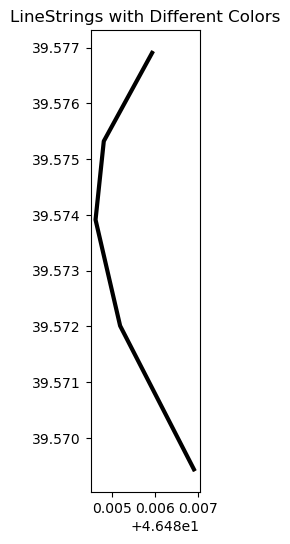

In [172]:
import matplotlib.pyplot as plt

# Plot each LineString with a different color
fig, ax = plt.subplots(figsize=(10, 6))
gdf = gpd.GeoDataFrame({"geometry":linestrings}, crs=edges.crs).iloc[[4, 5]]
# Use a colormap to assign unique colors
for i, line in enumerate(gdf["geometry"]):
    gdf.iloc[[i]].plot(ax=ax, color=plt.cm.tab10(i), label=f"Line {i + 1}")

gdf.iloc[[1]].plot(ax=ax, color='black', linewidth=3)
# Add legend and labels
ax.set_title("LineStrings with Different Colors")
plt.show()

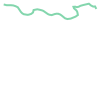

In [229]:
edges.loc[153].geometry.difference(edges.loc[153].geometry.intersection(edges.loc[1406].geometry))

In [315]:
transport_mode = 'roads'
special_suffix = "_osmsimp"  # _ximena leave empty "" otherwise
subfolder = os.path.join(input_folder, transport_mode.capitalize())
edges = loadAndFormatGeojson(transport_mode, "edges", subfolder, special_suffix)

nodes, edges = create_nodes_and_update_edges(edges)

# remove selfloop
cond = edges['end1'] == edges['end2']
if cond.sum() > 0:
    print(f"Removing {cond.sum()} self-loops")
    edges = edges[~cond]

# remove duplicated edges
cond = edges['geometry'].to_wkt().duplicated()
if cond.sum() > 0:
    print(f"Removing {cond.sum()} duplicated edges")
    edges = edges[~cond]

# if several edges have the same start and end points, keep only one
edges['end_set'] = edges.apply(lambda row: frozenset([row['end1'], row['end2']]), axis=1)  # Create a set representation of each row's end1 and end2
cond = edges['end_set'].duplicated()
if cond.sum() > 0:
    print(f"Removing {cond.sum()} edges that have the same endpoints")
    edges = edges[~cond]
edges = edges.drop(columns=['end_set'])  # Drop the temporary column
edges['id'] = list(range(edges.shape[0]))
edges.index = edges['id']
    
edges = treat_overlapping_edges(edges)
print(f"Check that all resulting geometries are LineString: {edges['geometry'].apply(lambda geom: geom.geom_type == 'LineString').all()}")

# add columns
edges['surface'] = 'paved'
if "surface" not in edges.columns:
    edges['surface'] = 'paved'
if "class" not in edges.columns:
    edges['class'] = None
if "disruption" not in edges.columns:
    edges['disruption'] = None
if "name" not in edges.columns:
    edges['name'] = None
if "special" not in edges.columns:
    edges['special'] = None

#nodes, edges = create_nodes_and_update_edges(edges)
#edges = remove_degree_2_nodes(edges)
#edges = addKm(edges, projected_crs)

print(f"There are {edges.shape[0]} edges")
print(edges.head())

# Exports
#export(nodes, edges, input_folder, output_folder, transport_mode, special_suffix)

There are 15294 edges
EPSG:4326
Removing 37 self-loops
Removing 61 duplicated edges
Removing 171 edges that have the same endpoints


Processing overlapping edges: 100%|████████████████████████████████████████████| 15025/15025 [00:14<00:00, 1071.60it/s]


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

<Axes: >

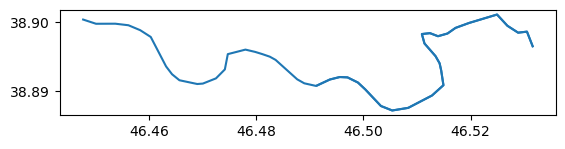

In [212]:
edges.loc[[153, 1406]].plot()

In [223]:
edges.loc[153, "geometry"].wkt

'LINESTRING (46.5316618158227 38.8963201426715, 46.5305253360001 38.89858368886154, 46.52887679999998 38.89843539999994, 46.52687428836688 38.89943876274292, 46.52494474950949 38.901068000600816, 46.5197253999999 38.8998441, 46.517193299999896 38.8991261, 46.515705599999976 38.89831429999999, 46.51392750572157 38.897921018984164, 46.51243329999998 38.898364399999984, 46.510921074656515 38.8982362532687, 46.51141049999989 38.8968632, 46.513474 38.895024399999976, 46.51423219999989 38.89398240000001, 46.51452319999998 38.8929568, 46.51494403671107 38.89080786439377, 46.51281599999988 38.8893144, 46.50837429999988 38.887519, 46.505391066565885 38.88713814767433, 46.50328879999988 38.8877862, 46.500370599999876 38.8901913, 46.49899729999991 38.8911933, 46.49704635044407 38.89194400069804, 46.4956068999999 38.891995, 46.49375440000003 38.89163409999985, 46.4911860911759 38.89070078615641, 46.48898660011175 38.89108300012184, 46.487667599999895 38.891661, 46.4836334999999 38.8944834, 46.4825

In [224]:
edges.loc[1406, "geometry"].wkt

'LINESTRING (46.5316618158228 38.896320142671684, 46.530525336000224 38.898583688861756, 46.5288768 38.89843540000017, 46.52687428836697 38.89943876274303, 46.52494474950961 38.901068000600766, 46.51972540000001 38.89984409999991, 46.51719330000001 38.89912609999992, 46.51570559999992 38.89831429999996, 46.513927505721604 38.897921018984086, 46.51243329999992 38.898364399999956, 46.51092107465656 38.89823625326863, 46.5114105 38.89686319999993, 46.513474 38.89502439999995, 46.5142322 38.893982399999935, 46.514523199999914 38.89295679999996, 46.51494403671113 38.890807864393686, 46.512816 38.88931439999992, 46.5083743 38.887519, 46.50539106656582 38.88713814767433, 46.5032888 38.88778619999992, 46.50037059999999 38.89019129999993, 46.49899730000001 38.89119329999992, 46.4970463504441 38.89194400069797, 46.49560690000001 38.891995, 46.49375439999994 38.891634099999976, 46.491186091175855 38.89070078615636)'

# Maritime

In [43]:
transport_mode = 'maritime'
special_suffix = "_mc"  # _ximena leave empty "" otherwise
subfolder = os.path.join(input_folder, transport_mode.capitalize())
edges = loadAndFormatGeojson(transport_mode, "edges", subfolder, special_suffix)

# create nodes from endpoints
endpoints = gpd.GeoDataFrame({"end1": edges.geometry.apply(lambda line: Point(line.coords[0])), "end2": edges.geometry.apply(lambda line: Point(line.coords[-1]))})
unique_endpoints = list(set(endpoints['end1'].to_list()) | set(endpoints['end2'].to_list()))
nodes = gpd.GeoDataFrame(geometry=unique_endpoints, crs=edges.crs)
nodes['id'] = range(nodes.shape[0])

# add nodes_id into end1 and end2 columns of edges
edges['end1'] = endpoints['end1'].map(nodes.set_index('geometry')['id'])
edges['end2'] = endpoints['end2'].map(nodes.set_index('geometry')['id'])

edges = addKm(edges, crs=3975) #for maritime we use 3975, which is projection for the whole world

print(nodes.head())
print(edges.head())

export(nodes, edges, input_folder, output_folder, transport_mode, special_suffix)

if (edges['end1'] == edges['end2']).any():
    print('ATT')

There are 112 edges
EPSG:4326
                    geometry  id
0        POINT (51 13.00001)   0
1          POINT (19.8 38.6)   1
2  POINT (33.75001 27.89998)   2
3          POINT (32.6 29.7)   3
4      POINT (41.2 16.29999)   4
      from_infra  to_infra    distance    length  id            km capacity  \
index                                                                         
0           None      None         NaN       NaN   0   7223.033494     None   
1           None      None         NaN       NaN   1   6337.468767     None   
2           None      None         NaN       NaN   2  24857.328586     None   
3           None      None         NaN       NaN   3   6546.422559     None   
4       maritime  maritime  532.647058  5.009238   4    585.160733     None   

       end1  end2 special  name  \
index                             
0        42    77    None  None   
1        77    62    None  None   
2        61    77    None  None   
3        61    82    None  None   
4       

C:\Users\Celian\miniforge3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Airways

In [19]:
transport_mode = 'airways'
subfolder = os.path.join(input_folder, transport_mode.capitalize())

nodes = loadAndFormatGeojson(transport_mode, "nodes", subfolder)
edges = loadAndFormatGeojson(transport_mode, "edges", subfolder)

edges = addKm(edges, projected_crs) #for maritime we use 3975, which is projection for the whole world
edges = assignEndpointsAndUpdateFullDf(edges, nodes)

print(nodes.head())
print(edges.head())

nodes.to_file(os.path.join(output_folder, transport_mode+"_nodes.geojson"), driver="GeoJSON", index=False)
edges.to_file(os.path.join(output_folder, transport_mode+"_edges.geojson"), driver="GeoJSON", index=False)

if (edges['end1'] == edges['end2']).any():
    print('ATT')

There are 3 nodes
epsg:4326
There are 3 edges
epsg:4326


C:\Users\colon\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Assigning end nodes to linestring
                                         name special  \
index                                                   
0      Aeropuerto Ecologico Galapagos Seymour    None   
1                        Aeropuerto Guayaquil    None   
2             Aeropuerto Quito Mariscal Sucre    None   

                         geometry  id  
index                                  
0      POINT (-90.26504 -0.45506)   0  
1      POINT (-79.88713 -2.15896)   1  
2      POINT (-78.35621 -0.12718)   2  
      special capacity                                           geometry  id  \
index                                                                           
0        None     None  LINESTRING (-90.26504 -0.45506, -78.35621 -0.1...   0   
1        None     None  LINESTRING (-78.35621 -0.12718, -79.88713 -2.1...   1   
2        None     None  LINESTRING (-79.88713 -2.15896, -90.26504 -0.4...   2   

       end1  end2           km  
index                           
0       

# Waterways

In [11]:
transport_mode = 'waterways'
subfolder = os.path.join(input_folder, transport_mode.capitalize())

nodes = loadAndFormatGeojson(transport_mode, "nodes", subfolder)
edges = loadAndFormatGeojson(transport_mode, "edges", subfolder)
edges = addKm(edges, projected_crs)
edges = assignEndpointsAndUpdateFullDf(edges, nodes)

print(nodes.head())
print(edges.head())

nodes.to_file(os.path.join(output_folder, transport_mode+"_nodes.geojson"), driver="GeoJSON", index=False)
edges.to_file(os.path.join(output_folder, transport_mode+"_edges.geojson"), driver="GeoJSON", index=False)

if (edges['end1'] == edges['end2']).any():
    print('ATT')

There are 22 nodes
epsg:4326
There are 20 edges
epsg:4326
Assigning end nodes to linestring


C:\Users\colon\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1250.87it/s]


       id                      name                    geometry
index                                                          
0       0          Chong Kneas Port  POINT (103.82202 13.26983)
1       1      Kampong Chlnang Port  POINT (104.68121 12.26825)
2       2  Kampong Chlnang Junction  POINT (104.69201 12.27107)
3       3         Kratie River Port  POINT (106.01621 12.48460)
4       4           Kratie Junction  POINT (106.01220 12.48335)
       end1  end2 special  capacity  id  \
index                                     
0         2     0    None  200000.0   0   
1        10     6    None   20000.0   1   
2         6     5    None   20000.0   2   
3         6     4    None   20000.0   3   
4         4     3    None       NaN   4   

                                                geometry          km  
index                                                                 
0      LINESTRING (104.69187 12.27092, 104.67544 12.3...  156.544324  
1      LINESTRING (104.95104 11.55619

# Multimodality

In [24]:
def find_anchor_points(nodes, mode):
    if mode == 'roads':
        return nodes
    elif mode == 'maritime':
        return nodes[nodes['port']]
    elif mode == 'railways':
        return nodes[nodes['station']]
    elif mode == 'airways':
        return nodes[nodes['airport']]
    elif mode == 'waterways':
        return nodes[nodes['port']]
    else:
        raise ValueError("Wrong mode choosen")


def build_multimodal_links(from_nodes, from_mode, to_nodes, to_mode):
    anchor_from_nodes = find_anchor_points(from_nodes, from_mode)
    anchor_to_nodes = find_anchor_points(to_nodes, to_mode)

    # Find the closest road for each port
    links = []
    projected_anchor_from_nodes = anchor_from_nodes.to_crs(epsg=3857)
    projected_anchor_to_nodes = anchor_to_nodes.to_crs(epsg=3857)
    for _, target_node in projected_anchor_to_nodes.iterrows():
        # Find the closest road point to the current port
        closest_from_nodes = projected_anchor_from_nodes.distance(target_node.geometry).idxmin()
        closest_point = projected_anchor_from_nodes.loc[closest_from_nodes].geometry
    
        # Create a LineString from port to closest road point
        link = LineString([target_node.geometry, closest_point])
        links.append({"geometry": link})
    
    # Create a new GeoDataFrame for the links
    links_gdf = gpd.GeoDataFrame(links, crs=projected_anchor_to_nodes.crs)
    links_gdf = links_gdf.to_crs(epsg=4326)
    links_gdf['multimodes'] = from_mode + '-' + to_mode
    return links_gdf

In [25]:
# automaed creationg of multimodal split
import geopandas as gpd
from shapely.geometry import LineString

multimode = ["roads", "maritime"]
suffix0 = "_osmsimp"
suffix1 = "_mc"

roads_nodes = gpd.read_file(os.path.join(input_folder, "Roads", "treated_roads_nodes_osmsimp.geojson"))
maritime_nodes = gpd.read_file(os.path.join(input_folder, "Maritime", "treated_maritime_nodes_mc.geojson"))
maritime_nodes['port'] = maritime_nodes['port'].map(lambda x: bool(x) if pd.notna(x) else False)
railways_nodes = gpd.read_file(os.path.join(input_folder, "Railways", "treated_railways_nodes.geojson"))
railways_nodes['station'] = railways_nodes['station'].map(lambda x: bool(x) if pd.notna(x) else False)

multimodal_edges = pd.concat([
    build_multimodal_links(roads_nodes, "roads", maritime_nodes, "maritime"),
    build_multimodal_links(roads_nodes, "roads", railways_nodes, "railways"),
    build_multimodal_links(railways_nodes, "railways", maritime_nodes, "maritime")
])
multimodal_edges['km'] = 0.1  # no impact
multimodal_edges['id'] = range(multimodal_edges.shape[0])
multimodal_edges['capacity'] = None
multimodal_edges.to_file(os.path.join(output_folder, "multimodal_edges_osmsimp.geojson"), driver="GeoJSON", index=False)

print(multimodal_edges.head())
print(multimodal_edges.shape)

                                            geometry      multimodes   km  id  \
0   LINESTRING (41.66864 41.6486, 41.66877 41.64588)  roads-maritime  0.1   0   
1  LINESTRING (51.22857 43.60237, 51.22302 43.60393)  roads-maritime  0.1   1   
2  LINESTRING (41.65711 42.15927, 41.66985 42.16787)  roads-maritime  0.1   2   
3  LINESTRING (49.73252 40.28461, 49.71417 40.28648)  roads-maritime  0.1   3   
0  LINESTRING (71.39464 42.94935, 71.37812 42.94671)  roads-railways  0.1   4   

  capacity  
0     None  
1     None  
2     None  
3     None  
0     None  
(38, 5)


# Railways

In [72]:
transport_mode = 'railways'

subfolder = os.path.join(input_folder, transport_mode.capitalize())
edges = loadAndFormatGeojson(transport_mode, "edges", subfolder)
nodes, edges = create_nodes_and_update_edges(edges)

edges = addKm(edges, projected_crs)
edges['disruption'] = None

print(nodes.head())
print(edges.head())

if (edges['end1'] == edges['end2']).any():
    print('ATT')

export(nodes, edges, input_folder, output_folder, transport_mode, special_suffix="")

There are 31 edges
EPSG:4326
                    geometry  id
0  POINT (71.39464 42.94935)   0
1   POINT (45.2105 41.37973)   1
2  POINT (44.87981 41.65591)   2
3  POINT (82.60064 45.07896)   3
4  POINT (43.64281 40.74461)   4
      OBJECTID NAME1 NAME2 NAME3 ISO_CC RR_FEATURE Shape_Length special  \
index                                                                     
0         None  None  None  None   None       None         None    None   
1         None  None  None  None   None       None         None    None   
2         None  None  None  None   None       None         None    None   
3         None  None  None  None   None       None         None    None   
4         None  None  None  None   None       None         None    None   

                                                geometry  id  end1  end2  \
index                                                                      
0      LINESTRING (51.22432 43.59837, 51.22589 43.606...   0    33    27   
1      LINESTRING (

C:\Users\Celian\miniforge3\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# Other stuff, may be useful

### Transition from shp to geojson

In [47]:
for edge_node in ["node", "edge"]:    
    transport_mode = 'roads'
    version = "v8"
    subfolder = os.path.join(folder, 'Data', "Structured", transport_mode.capitalize(), version)

    filename = "raw_"+transport_mode+"_"+edge_node+"s.shp"
    df = gpd.read_file(os.path.join(subfolder, filename))

    version = "current_version"
    subfolder = os.path.join(folder, 'Data', "Structured", transport_mode.capitalize(), version)
    df.to_file(os.path.join(subfolder, "raw_"+transport_mode+"_"+edge_node+"s.geojson"), driver="GeoJSON")

### Change to CRS 4326

In [76]:
for edge_node in ["node", "edge"]:    
    transport_mode = 'multimodal'
    version = "current_version"
    subfolder = os.path.join(folder, 'Data', "Structured", transport_mode.capitalize(), version)
    
    filename = "raw_"+transport_mode+"_"+edge_node+"s.shp"
    df = gpd.read_file(os.path.join(subfolder, "raw_"+transport_mode+"_"+edge_node+"s.geojson"))
    
    df = df.to_crs(4326)
    
    df.to_file(os.path.join(subfolder, "raw_"+transport_mode+"_"+edge_node+"s.geojson"), driver="GeoJSON")